In [1]:
import pandas as pd
import numpy as np
import wrangle
import seaborn as sns
import warnings
import pydataset
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
swiss = pydataset.data('swiss')
swiss

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6
Porrentruy,76.1,35.3,9,7,90.57,26.6
Broye,83.8,70.2,16,7,92.85,23.6
Glane,92.4,67.8,14,8,97.16,24.9
Gruyere,82.4,53.3,12,7,97.67,21.0
Sarine,82.9,45.2,16,13,91.38,24.4


<Figure size 720x576 with 0 Axes>

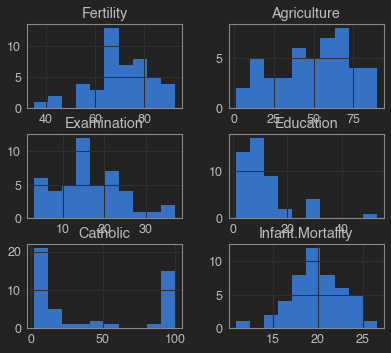

In [34]:
import jupyterthemes as jp
jp.jtplot.style()
plt.figure(figsize=(10,8))
swiss.hist()
plt.show()

In [3]:
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [4]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(swiss, 'Fertility' )

In [5]:
def select_kbest(X, y, k):
    f_selector = SelectKBest(f_regression, k)
    f_selector.fit(X, y)
    feature_mask = f_selector.get_support()

    f_feature = X.iloc[:,feature_mask].columns.tolist()
    return f_feature

def rfe(X,y,k):
    lm = LinearRegression()
    rfe = RFE(lm,k)
    rfe.fit(X, y)
    feature_mask_rfe = rfe.support_
    rfe_feature = X.iloc[:,feature_mask_rfe].columns.tolist()
    return rfe_feature

In [6]:
def scale_data(train,validate,test):
    '''Accepts train, validate, test data frames and applies min-max scaler
    return: train, validate, test scaled pandas dataframe'''
    
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    validate_scaled = scaler.transform(validate)
    test_scaled = scaler.transform(test)
    
    train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
    validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
    test_scaled = pd.DataFrame(test_scaled, columns=train.columns)
    
    return train_scaled, validate_scaled, test_scaled

In [7]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test)

In [8]:
select_kbest(X_train_scaled, y_train, 3)

['Examination', 'Catholic', 'Infant.Mortality']

In [9]:
rfe(X_train_scaled, y_train, 3)

['Agriculture', 'Examination', 'Infant.Mortality']

In [10]:

# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict pred_mean
Fert_pred_mean = y_train.Fertility.mean()
y_train['Fert_pred_mean'] = Fert_pred_mean
y_validate['Fert_pred_mean'] = Fert_pred_mean

In [11]:
# 2. compute pred_median
Fert_pred_median = y_train.Fertility.median()
y_train['Fert_pred_median'] = Fert_pred_median
y_validate['Fert_pred_median'] = Fert_pred_median

# 3. RMSE of pred_mean
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of pred_median
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_median) ** .5
rmse_validate = mean_squared_error(y_train.Fertility, y_train.Fert_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  9.77 
Validate/Out-of-Sample:  14.78
RMSE using Median
Train/In-Sample:  9.78 
Validate/Out-of-Sample:  9.78


In [12]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train_scaled, y_train.Fertility)

# predict train
# 
# use the thing!
# 
y_train['Fert_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_lm) ** (1/2)

# predict validate
y_validate['Fert_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  4.571043042889271 
Validation/Out-of-Sample:  12.132738217927692


In [13]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.Fertility)

# predict train
y_train['Fert_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_lm) ** (1/2)

# predict validate
y_validate['Fert_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  4.571043042889271 
Validation/Out-of-Sample:  12.132738217927692


In [14]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.Fertility)

# predict train
y_train['Fert_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_glm) ** (1/2)

# predict validate
y_validate['Fert_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.Fertility, y_train.Fert_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  4.480345159948017 
Validation/Out-of-Sample:  4.480345159948017


In [15]:
r2_score(y_train.Fertility, y_train.Fert_pred_lm)

0.7812685238494381

In [16]:
r2_score(y_validate.Fertility, y_validate.Fert_pred_lm)

0.27597473375077475

In [17]:
r2_score(y_train.Fertility, y_train.Fert_pred_lars)

0.17065056607691342

In [18]:
r2_score(y_validate.Fertility, y_validate.Fert_pred_lars)

-0.046119289586445955

In [19]:
r2_score(y_train.Fertility, y_train.Fert_pred_glm)

0.7898624774356635

In [20]:
r2_score(y_validate.Fertility, y_validate.Fert_pred_glm)

0.27148108455937203

In [21]:
X_train_scaled['is_Catholic']= X_train_scaled.Catholic.apply(lambda x: 1 if x >= 0.5 else 0)
X_train_scaled.is_Catholic

0     0
1     0
2     0
3     1
4     0
5     0
6     0
7     1
8     1
9     0
10    1
11    0
12    0
13    1
14    1
15    0
16    0
17    1
18    1
19    1
20    0
21    0
22    0
23    1
24    0
Name: is_Catholic, dtype: int64

In [22]:
features = ['Infant.Mortality','Examination','is_Catholic']
X_train_scaled = X_train_scaled[features]

In [23]:
X_validate_scaled['is_Catholic']= X_validate_scaled.Catholic.apply(lambda x: 1 if x >= 0.5 else 0)
X_validate_scaled = X_validate_scaled[features]

In [24]:
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train_scaled, y_train.Fertility)

# predict train
# 
# use the thing!
# 
y_train['Fert_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_lm) ** (1/2)

# predict validate
y_validate['Fert_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  5.111329150757147 
Validation/Out-of-Sample:  12.781771268310699


In [25]:
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.Fertility)

# predict train
y_train['Fert_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_lm) ** (1/2)

# predict validate
y_validate['Fert_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  5.111329150757147 
Validation/Out-of-Sample:  12.781771268310699


In [26]:
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.Fertility)

# predict train
y_train['Fert_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_glm) ** (1/2)

# predict validate
y_validate['Fert_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.Fertility, y_train.Fert_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  5.023266910079732 
Validation/Out-of-Sample:  5.023266910079732


In [27]:
r2_score(y_train.Fertility, y_train.Fert_pred_lm)

0.7265056493459614

In [28]:
r2_score(y_validate.Fertility, y_validate.Fert_pred_lm)

0.19644029482609182

In [29]:
r2_score(y_train.Fertility, y_train.Fert_pred_lars)

0.22185332481121145

In [30]:
r2_score(y_validate.Fertility, y_validate.Fert_pred_lars)

-0.055453769440209744

In [31]:
r2_score(y_train.Fertility, y_train.Fert_pred_glm)

0.7358484447263218

In [32]:
r2_score(y_validate.Fertility, y_validate.Fert_pred_glm)

0.21501211856678992

In [33]:
explained_variance_score(y_validate.Fertility, y_validate.Fert_pred_lm)

0.21765149243765736